In [112]:
import pickle
import time
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
from random import randint
import matplotlib.pyplot as plt

In [183]:
books = pd.read_csv("books_cleaned.csv")
books = books.loc[books["is_analysed"] ==1, :]

with open(r"df_pivot_sparse.pickle", "rb") as output_file:
    pivot_sparse=pickle.load(output_file)
with open(r"df_columns.pickle", "rb") as output_file:
    columns = pickle.load(output_file)
with open(r"df_index.pickle", "rb") as output_file:
    indexes =pickle.load(output_file)

In [149]:
import difflib

class SM(difflib.SequenceMatcher):
    def __init__(self,a):
        super().__init__(a=a)
    def __call__(self,b):
        self.set_seq2(b)
        return self.ratio()

In [150]:
# if searched title matches title in dataset exatcly, return this information, otherwise match with sequence matcher and
# return information for matched title
def get_title_info(desired_title):
    desired_title = desired_title.lower()
    
    row = books.loc[books["title"].str.lower() == desired_title, :]
    if row.empty:
        close_name = SM(desired_title)
        words_list = [books["title"].drop_duplicates().str.lower().values.tolist()][0]
        best_match = max(words_list, key=close_name)
        row = books.loc[books["title"].str.lower() == best_match, :]
        
    author = list(row["author"])[0]
    title = list(row["title"])[0]
    author_title = list(row["authortitle"])[0]
    return author, title, author_title

In [151]:
# return recommendations in nicer format, also possibly drop recommendations from same author
def suggestions_to_dict(suggestions, s_author="", n_required=5):
    res_dict = {}
    suggestions = columns.values[suggestions]
    for sug in suggestions:
        row = books.loc[books["authortitle"] == sug, :]   
        author = list(row["author"])[0]
        if (s_author!="") & (author==s_author):
            continue
        title = list(row["title"])[0]
        res_dict[sug] = [author, title]
        if len(res_dict.keys()) == n_required:    
            return res_dict       

In [152]:
def print_suggestion(res_dict):
    for k, v in res_dict.items():
        print(f"Recommending {v[1]} from {v[0]}") 

#### User-based CF:
- user based method had great feedback from users in paper build on this dataset
- using equation from https://www.geeksforgeeks.org/user-based-collaborative-filtering/  (corrected for typo)
- BUT user-based algoritms probably won't work because we have only one user preference

In [118]:
s_title = "the lord of the rings"
author, title, author_title = get_title_info(s_title)
new_user = [0] * pivot_sparse.shape[1]
new_user[columns.values.tolist().index(author_title)] = 10
print(f"Searching recommendations for {title} from {author}:")

Searching recommendations for The Lord of the Rings from J. R. R Tolkien:


In [60]:
# this part would be calculated only once and saved
def model_to_save(df):
    diff_from_mean = df - df.mean(axis=1)
    normalizer_b = np.sqrt(np.sum(np.square(diff_from_mean), axis=1))
    return diff_from_mean, normalizer_b
diff_from_mean, normalizer_b = model_to_save(pivot_sparse)    

In [61]:
# this would be calculated for every recommendation (reasonably fast maybe)
def similarity_user_users(ratings_a, diff_from_mean, normalizer_b):
    mean_rating_a = np.mean(ratings_a)
    diff_from_mean_a = ratings_a - mean_rating_a
    normalizer_a = np.sqrt(np.sum(np.square(diff_from_mean_a)))
    sim_not_normalized = np.sum(diff_from_mean_a @ diff_from_mean.T)
    normalizer = normalizer_a * normalizer_b
    sim = sim_not_normalized / np.array(normalizer).flatten()
    recoms = mean_rating_a + (sim.T @ pivot_sparse) / np.sum(sim)
    return recoms

In [62]:
# suggest the most popular books in general, problem in user-based approach, try only item-based from now on
sims = similarity_user_users(new_user, diff_from_mean, normalizer_b)
suggestions = sims.argsort()[-15:][::-1]
sug_dict = suggestions_to_dict(suggestions)
print_suggestion(sug_dict)

Recommending Wild Animus from Rich Shapero
Recommending The Lovely Bones: A Novel from Alice Sebold
Recommending The Da Vinci Code from Dan Brown
Recommending Bridget Jones's Diary from Helen Fielding
Recommending The Nanny Diaries: A Novel from Emma McLaughlin


#### Item-based CF with kNN:
- kNN seems like a popular algoritm for recommender systems
- model size = dataset size less than 5 MB (ok)
- results seem reasonable

In [157]:
s_title = "The Lord of the Rings"
author, title, author_title = get_title_info(s_title)
s_ratings = pivot_sparse.T[columns.values.tolist().index(author_title)]
print(f"Searching recommendations for {title} from {author}:")

Searching recommendations for The Lord of the Rings from J. R. R Tolkien:


In [158]:
model = NearestNeighbors(metric="cosine", algorithm='brute')
model.fit(pivot_sparse.T)

NearestNeighbors(algorithm='brute', metric='cosine')

In [160]:
distances, suggestions = model.kneighbors(s_ratings.reshape(1, -1), 15)
sug_dict = suggestions_to_dict(suggestions.tolist()[0], n_required=15)
print_suggestion(sug_dict)

Recommending The Lord of the Rings from J. R. R Tolkien
Recommending Harry Potter and the Chamber of Secrets (Book 2) from J. K. Rowling
Recommending Harry Potter and the Prisoner of Azkaban (Book 3) from J. K. Rowling
Recommending The Hobbit: Or There and Back Again from J. R. R Tolkien
Recommending Harry Potter and the Goblet of Fire (Book 4) from J. K. Rowling
Recommending Harry Potter and the Order of the Phoenix (Book 5) from J. K. Rowling
Recommending Harry Potter and the Sorcerer's Stone (Book 1) from J. K. Rowling
Recommending The Silmarillion from J. R. R Tolkien
Recommending The Gunslinger (The Dark Tower, Book 1) from Stephen King
Recommending Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) from J. K. Rowling
Recommending A Time to Kill from JOHN GRISHAM
Recommending The Da Vinci Code from DAN BROWN
Recommending The Drawing of the Three (The Dark Tower, Book 2) from Stephen King
Recommending Interview With the Vampire from ANNE RICE
Recommending Silence of t

#### Item-based CF with cosine distances:
- popular method for recommender systems
- correlations are simple too but not implemented for sparse matrices, would have to write it myself
- model size = datasetsize less than 5 MB (ok)
- result ok

In [164]:
s_title = "wuthering heights"
s_author, s_title, s_author_title = get_title_info(s_title)
s_ratings = pivot_sparse.T[columns.values.tolist().index(s_author_title)]
print(f"Searching recommendations for {s_title} from {s_author}:")

Searching recommendations for WUTHERING HEIGHTS from EMILY BRONTE:


In [171]:
cos_to_other = cosine_similarity(pivot_sparse.T, s_ratings).flatten()
suggestions = cos_to_other.argsort()[-16:][::-1]
sug_dict = suggestions_to_dict(suggestions[1:], n_required=15)
print_suggestion(sug_dict)

Recommending The TEMPEST from William Shakespeare
Recommending The Joy Luck Club from Amy Tan
Recommending Blood and Honor from W. E. B. Griffin
Recommending Uncle Tom's Cabin (Bantam Classics) from Harriet Beecher Stowe
Recommending To Kill a Mockingbird from Harper Lee
Recommending Howards End from E M Forster
Recommending Jane Eyre from Charlotte Bronte
Recommending Three Musketeers from Alexandre Dumas
Recommending Bleak House (Bantam Classics) from Charles Dickens
Recommending My Antonia (Dover Thrift Editions) from Willa Cather
Recommending Message In a Bottle from Nicholas Sparks
Recommending A Time to Kill from JOHN GRISHAM
Recommending The Declaration of Independence and Other Great Documents of American History, 1775-1865 (Dover Thrift Editions) from John Grafton
Recommending Sphere from MICHAEL CRICHTON
Recommending The Bell Jar from Sylvia Plath


#### Results evaluation:
- using 1/0 simplifies evaluation metrics and has nice interpretation of whether user bought the book or not, which would be of interest in many applications => using 0/1 from now on
- evaluation based on recall, precision and probability that user (that made the search) already bought/mentioned recommended book
- recall and precision depend on number of recommendations so let add probability max and min to see optimal number of recommendations, Goodreads has 4 on main page so 5 seems like a good number to start
- don't recommend books from the same author (Goodreads approach)

In [120]:
def recall_from_res_dict(res_dict):
    recalls = []
    for k, v in res_dict.items():
        # indexes of recommended books and searched book
        sample_indexes = np.where(np.isin(columns.values.tolist(), v))[0].tolist()
        s_index = np.where(np.isin(columns.values.tolist(), [k]))[0].tolist()
        
        # limit to users who bought searched book and sum number of books for each user
        all_ones = pd.Series([1] * pivot_sparse_1.shape[1]).values.reshape(-1,1)
        sample_all_books=pivot_sparse_1[np.array((pivot_sparse_1.T[s_index]>0).todense())[0], :]
        sum_users = (all_ones.T @ sample_all_books.T)[0]
        
        # number of recommended and bought books (success) for each user
        sample=sample_all_books[:, sample_indexes]
        all_ones = pd.Series([1] * sample.shape[1]).values.reshape(-1,1)
        sum_users_suc_recommended = (all_ones.T @ sample.T)[0]
        
        # median of ratio of recommended and bought books vs. all bought books across all users (that bought searched book)
        recall = sum_users_suc_recommended/sum_users
        recalls.append(np.median(recall)) 
    return recalls  

In [121]:
def precision_from_res_dict(res_dict, n_recommendations=5):
    precs = []
    for k, v in res_dict.items():
        # indexes of recommended books and searched book
        sample_indexes = np.where(np.isin(columns.values.tolist(), v))[0].tolist()
        s_index = np.where(np.isin(columns.values.tolist(), [k]))[0].tolist()
        
        # number of recommended and bought books (success) for each user
        sample=pivot_sparse_1[np.array((pivot_sparse_1.T[s_index]>0).todense())[0], :][:, sample_indexes]
        all_ones = pd.Series([1] * sample.shape[1]).values.reshape(-1,1)
        sum_users_suc_recommended = (all_ones.T @ sample.T)[0]
        
        # median of ratio of recommended and bought books vs n of recommends across all users (that bought searched book)
        prec = sum_users_suc_recommended/n_recommendations
        precs.append(np.median(prec)) 
        
    return precs

In [122]:
def probs_from_res_dict(res_dict):
    maxs = []
    mins = []
    for k, v in res_dict.items():
        # indexes of recommended books and searched book
        sample_indexes = np.where(np.isin(columns.values.tolist(), v))[0].tolist()
        s_index = np.where(np.isin(columns.values.tolist(),[k]))[0].tolist()
        
        # for users who bought searched book, what is the probability that they have other recommended books?
        # take book with highest probability and book with lowest probability
        sample=pivot_sparse_1[np.array((pivot_sparse_1.T[s_index]>0).todense())[0], :][:, sample_indexes]
        sample_df = pd.DataFrame(sample.todense())
        probs = sample_df.mean(axis=0)
        maxs.append(probs.max())
        mins.append(probs.min())
    return maxs, mins   

In [184]:
# easier to work with 1/0 for recall and precision calculation
# make matrix a bit less sparse, first limit users, then books so that there are no books with zero ratings
# 30 is arbitrary number, try a few more options in pipeline but more strict will always lead to better recall and precision so
# there should be penalization that incorporates all the books that dont have rating
# at the same time book swith less rating are probably less searched so they should have lower weight

pivot_sparse_1 = pivot_sparse.copy()
pivot_sparse_1[pivot_sparse_1 != 0] = 1

all_ones = pd.Series([1] * pivot_sparse_1.shape[1]).values.reshape(-1,1)
sum_users = (all_ones.T @ pivot_sparse_1.T)[0]
pivot_sparse_1 = pivot_sparse_1[sum_users>30, :]

all_ones = pd.Series([1] * pivot_sparse_1.shape[0]).values.reshape(-1,1)
sum_books = (all_ones.T @ pivot_sparse_1)[0]
pivot_sparse_1 = pivot_sparse_1[:, sum_books>30]

columns = columns[sum_books>30]

books["is_analysed"] = 0
books.loc[books["authortitle"].isin(columns), "is_analysed"] = 1
books.to_csv("books_cleaned_limited.csv")

pivot_sparse_1.shape

(3082, 1841)

In [124]:
# estimate evaluation metrics on smaller sample - faster
rand_indexes = list(set([randint(0, pivot_sparse_1.shape[1]-1) for p in range(0, 1000)]))

In [126]:
# option 1: cosine + 0/1 rating
start_time = time.time()
res_dict = {}
for e, col in enumerate(pivot_sparse_1.T[rand_indexes]):
    cos_to_other = cosine_similarity(pivot_sparse_1.T, col).flatten()
    suggestions = cos_to_other.argsort()[-100:][::-1]
    s_author = list(books.loc[books["authortitle"] == columns[rand_indexes[e]], "author"])[0]   
    sug_dict = suggestions_to_dict(suggestions, s_author=s_author)
    res_dict[columns[rand_indexes[e]]] = list(sug_dict.keys())

end_time = time.time()
print(end_time - start_time)

precs = precision_from_res_dict(res_dict)
recalls = recall_from_res_dict(res_dict)
maxs, mins = probs_from_res_dict(res_dict)

113.83063983917236


In [127]:
# option 2: kNN + 0/1 rating
model = NearestNeighbors(metric="cosine", algorithm='brute')
model.fit(pivot_sparse_1.T)

start_time = time.time()
res_dict2 = {}
for e, col in enumerate(pivot_sparse_1.T[rand_indexes]):
    s_author = list(books.loc[books["authortitle"] == columns[rand_indexes[e]], "author"])[0]  
    distances, suggestions = model.kneighbors(col.reshape(1, -1), 100)
    sug_dict = suggestions_to_dict(suggestions.tolist()[0], s_author=s_author)
    res_dict2[columns[rand_indexes[e]]] = list(sug_dict.keys())
    
end_time = time.time()
print(end_time - start_time)

precs2 = precision_from_res_dict(res_dict2)
recalls2 = recall_from_res_dict(res_dict2)
maxs2, mins2 = probs_from_res_dict(res_dict2)

121.11677479743958


In [128]:
# option 4: cosine + 0/1 rating + allow for same author but not same book
start_time = time.time()
res_dict4 = {}
for e, col in enumerate(pivot_sparse_1.T[rand_indexes]):
    cos_to_other = cosine_similarity(pivot_sparse_1.T, col).flatten()
    suggestions = cos_to_other.argsort()[-6:][::-1]  
    sug_dict = suggestions_to_dict(suggestions[1:])
    res_dict4[columns[rand_indexes[e]]] = list(sug_dict.keys())

end_time = time.time()
print(end_time - start_time)

precs4 = precision_from_res_dict(res_dict4)
recalls4 = recall_from_res_dict(res_dict4)
maxs4, mins4 = probs_from_res_dict(res_dict4)

44.63127899169922


In [129]:
# precision and recall seem reasonable (wouldn't want zeroes)
# difference between best recommendation and worst recommendation (min and max) also not that big
len_max = len(maxs)
res_df = pd.DataFrame({"max_probs": maxs+maxs2+maxs4, 
                       "min_probs": mins+mins2+mins4,
                       "precision": precs+precs2+precs4,
                       "recall": recalls+recalls2+recalls4,
                       "estimator": ["cosine"]*len_max + ["kNN"]*len_max + ["cosine_author"]*len_max})
res_df.to_csv("res_df.csv")
res_df.groupby("estimator").median().round(6)

,max_probs,min_probs,precision,recall
estimator,,,,
cosine,0.307692,0.148936,0.2,0.009717
cosine_author,0.330097,0.170732,0.2,0.011085
kNN,0.307692,0.148936,0.2,0.009804


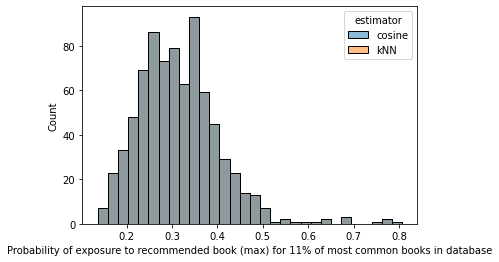

In [130]:
# there is no difference between kNN and cosine (probably because both use cosine distance metric) so drop kNN
ax = sns.histplot(data=res_df.loc[res_df["estimator"].isin(["cosine", "kNN"]), :], x="max_probs", hue="estimator", bins=30)
ax.set(xlabel='Probability of exposure to recommended book (max) for 11% of most common books in database');

In [131]:
res_df = res_df.loc[res_df["estimator"].isin(["cosine", "cosine_author"]), :]

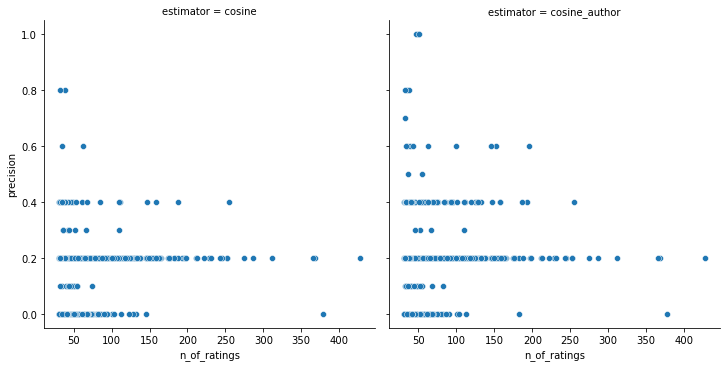

In [132]:
# how does precision depend on number of available ratings?
# for small number of ratings, high variablitiy in precision, maybe too much noise? 
# it seems like raising the limit to 40 ratings could be good idea
# for more ratings, precision converges to reasonable value (not too low) so probably ok
sample_sparse_1 = pivot_sparse_1[:, rand_indexes]
all_ones = pd.Series([1] * sample_sparse_1.shape[0]).values.reshape(-1,1)
sum_books = (all_ones.T @ sample_sparse_1)[0]
res_df.loc[:, "n_of_ratings"] = np.array([sum_books] * 2).flatten()
sns.relplot(data=res_df, x="n_of_ratings", y="precision", col="estimator", kind="scatter")

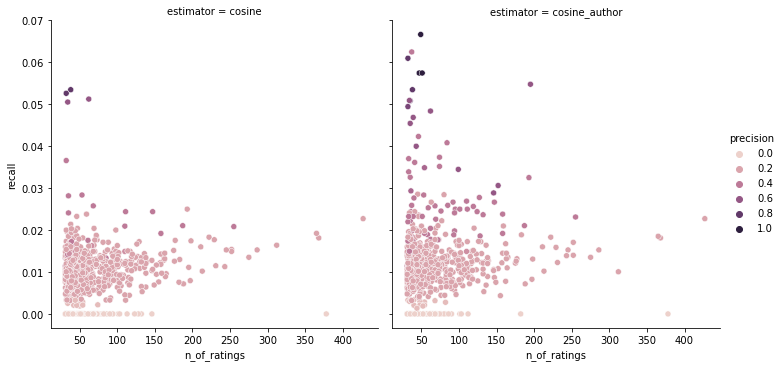

In [133]:
# the same as for precision, line of zero values on the bottom has also zero precision 
# so they are probably just bad predicitons
# high recall is connected to precision of 1, that is too much, probably caused by not enough ratings
sns.relplot(data=res_df, x="n_of_ratings", y="recall", col="estimator", kind="scatter", hue="precision")

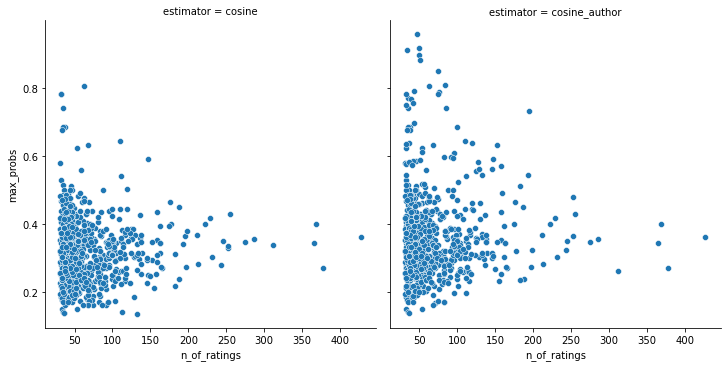

In [134]:
# probability 0.8 seems too high, another indication to make the ratings threshold higher 
g = sns.relplot(data=res_df, x="n_of_ratings", y="max_probs", col="estimator", kind="scatter")

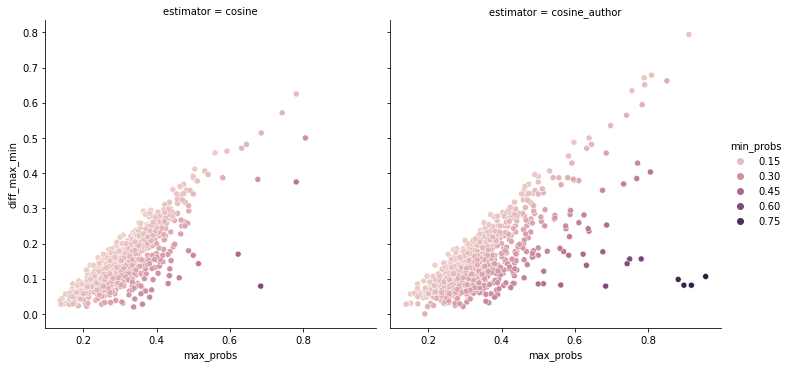

In [135]:
# we would't want to see narrow line, this seems ok
# inclusion for books by same author allows for more recommendations
res_df["diff_max_min"] = res_df["max_probs"] - res_df["min_probs"]
g = sns.relplot(data=res_df, x="max_probs", y="diff_max_min", col="estimator",kind="scatter", hue="min_probs")
#g._legend.remove()

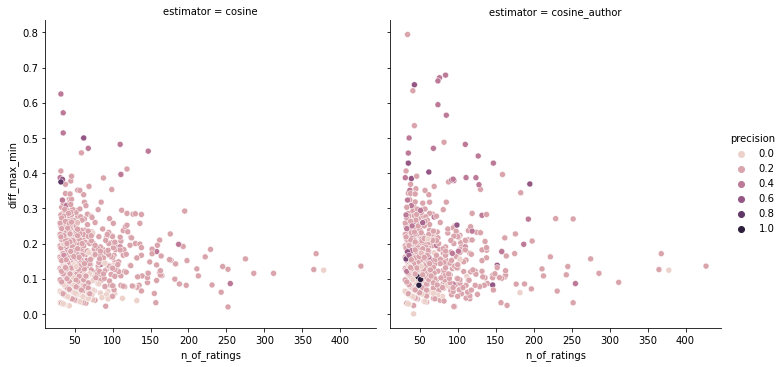

In [191]:
# do reccomendations deteriorate faster when number of observations is low? no
# number of ratings available does not improve the worst recommendation so we couln't add more recomendations as users grow
# there doesnt seem to be a relationship with precision 
res_df["diff_max_min"] = (res_df["max_probs"] - res_df["min_probs"])/1
sns.relplot(data=res_df, x="n_of_ratings", y="diff_max_min", col="estimator",kind="scatter", hue="precision")

Limitations and TODO:
- results seem more or less ok
- implemented sequence matcher can correct typos in search but has problem if different number of words in title, search whisperer would be much better
- data cleaning is the bottle neck, titles contain extra words like set or edition, unreadable characters and slight differences: 'Helen FieldingBridget Jones: The Edge of Reason' and 'Helen FieldingBridget Jones : The Edge of Reason'
- recommendations for only small portion of books, for the rest recommend the most popular in given category (one of Amazon approaches, categories would be needed). 
- also test more recommendation methods and use of continuous (0-10) vs. categorical (0/1) ratings => build a pipeline. For continous ratings use metrics that take them into account (MSE, ...)
- once we have more information about user preferences, we should try different recommendation method (maybe user-based) 
- see difference in performace in training/test sample, evaluate on test sample where possible (more than 50 ratings) and where not, at least adjust expected metrics by difference computed on test sample, even though cosine distance model is not likely to overfit  

#### Implementation:
- connected to bookstore db, make query, no need to load books.csv file and use additional new resources, but need to add unique identified column (other than ISBN) and "recomendations exist" column
- when user looks at book, show recomendations from dictionary saved in memory
- make prediction only when new book is added and sufficient number of known users (with already existing preference) bought it, add it to dictionary
- this is quite lightweight so small AWS lightsail instance would be enought but  + regular trafic
- once a while as number of ratings grow, recompute whole dictionary but could be constly so only once number of users with more than 3? ratings grows by 10%?, buy AWS EC2 instance and kill it afterwards but should be done automatically (teraform?) 
- current model uses so little data that probably could be recalculated at night at existing server

In [185]:
# cosine + 0/1 rating + allow for same author but not same book
res_dict_implement = {}
for e, col in enumerate(pivot_sparse_1.T):
    cos_to_other = cosine_similarity(pivot_sparse_1.T, col).flatten()
    suggestions = cos_to_other.argsort()[-6:][::-1]  
    sug_dict = suggestions_to_dict(suggestions[1:])
    res_dict_implement[columns[e]] = list(sug_dict.keys())

In [188]:
with open(r"res_dict.pickle", "wb") as output_file:
    pickle.dump(res_dict_implement, output_file)

"res_dict.pickle" and "books_cleaned_limited.csv" are necessary for flask web application so they need to be moved to web application folder (app)